In [27]:
from copy import deepcopy as copy
import numpy as np
import os
import time
from functools import partial
from disp import get_ordered_colors
from aux import gaussian_if_under_val, exp_if_under_val
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import multiprocessing as mp
import seaborn as sns

import cma
from sklearn.decomposition import PCA

from rate_network import simulate, tanh, generate_gaussian_pulse

## Meta learning and model params

In [2]:
# Meta learning params
N_NETWORKS = 10
POOL_SIZE = 10
N_INNER_LOOP_ITERS = 100
STD_EXPL = 0.001
L1_PENALTY = 1

# Model params
T = 0.1
dt = 1e-4
t = np.linspace(0, T, int(T / dt))
n_e = 15
n_i = 20

In [3]:
# Define learning rule names
if not os.path.exists('sims_out'):
	os.mkdir('sims_out')

out_dir = f'sims_out/{datetime.now()}'
os.mkdir(out_dir)
os.mkdir(os.path.join(out_dir, 'outcmaes'))

layer_colors = get_ordered_colors('winter', 15)

rule_names = [
	r'',
	r'$y$',
	r'$x$',
	r'$y^2$',
	r'$x^2$',
	r'$x \, y$',
	r'$x \, y^2$',
	r'$x^2 \, y$',
	r'$x^2 \, y^2$',
	r'$y_{int}$',
	r'$x \, y_{int}$',
	r'$x_{int}$',
	r'$x_{int} \, y$',

	r'$w$',
	r'$w \, y$',
	r'$w \, x$',
	r'$w \, y^2$',
	r'$w \, x^2$',
	r'$w \, x \, y$',
	r'$w \, x \, y^2$',
	r'$w \, x^2 \, y$',
	r'$w \, x^2 \, y^2$',
	r'$w y_{int}$',
	r'$w x \, y_{int}$',
	r'$w x_{int}$',
	r'$w x_{int} \, y$',

	r'$w^2$',
	r'$w^2 \, y$',
	r'$w^2 \, x$',
	r'$w^2 \, y^2$',
	r'$w^2 \, x^2$',
	r'$w^2 \, x \, y$',
	r'$w^2 \, x \, y^2$',
	r'$w^2 \, x^2 \, y$',
	r'$w^2 \, x^2 \, y^2$',
	r'$w^2 y_{int}$',
	r'$w^2 x \, y_{int}$',
	r'$w^2 x_{int}$',
	r'$w^2 x_{int} \, y$',
]

rule_names = [
	[r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
	[r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
	[r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

## Initial weights

In [32]:
# Transfer functions with threshold fixed to 0.1
transfer_e = partial(tanh, v_th=0.1)
transfer_i = partial(tanh, v_th=0.1)

plasticity_coefs = np.zeros(117)

# E->E, E->I, and I->E weights; why divide by dt?
w_e_e = 0.2e-3 / dt
w_e_i = 0.5e-4 / dt
w_i_e = -0.25e-4 / dt

# Create random initial weight matrices for N_NETWORKS of shape [n_target_neurons, n_source_neurons]
all_w_initial = []

for i in range(N_NETWORKS):
	w_initial = np.zeros((n_e + n_i, n_e + n_i))
	ring_connectivity = w_e_e * 0.5 * (1 + np.cos(2 * np.pi / n_e * np.arange(n_e)))
	for r_idx in np.arange(n_e):
		w_initial[r_idx:n_e, r_idx] = ring_connectivity[:(n_e - r_idx)]
		w_initial[:r_idx, r_idx] = ring_connectivity[(n_e - r_idx):]

	# Scale E->E wts randomly bw 0.6 and 1.0
	w_initial[:n_e, :n_e] = w_initial[:n_e, :n_e] * (0.6 + 0.4 * np.random.rand(n_e, n_e))

	# E->I wts; 
	w_initial[n_e:, :n_e] = gaussian_if_under_val(1.01, (n_i, n_e), w_e_i, 0.3 * w_e_i)

	# I->E wts
	w_initial[:n_e, n_e:] = gaussian_if_under_val(1.01, (n_e, n_i), w_i_e, 0.3 * np.abs(w_i_e))

	all_w_initial.append(w_initial)

<Figure size 400x400 with 0 Axes>

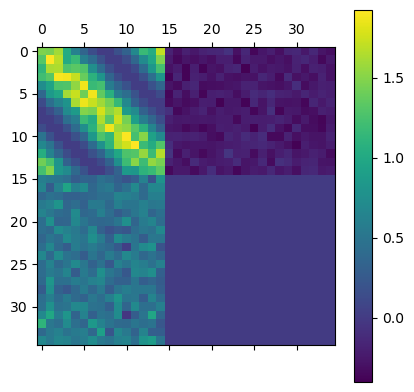

In [39]:
plt.figure(figsize=(4, 4))
plt.matshow(all_w_initial[3])
plt.colorbar();

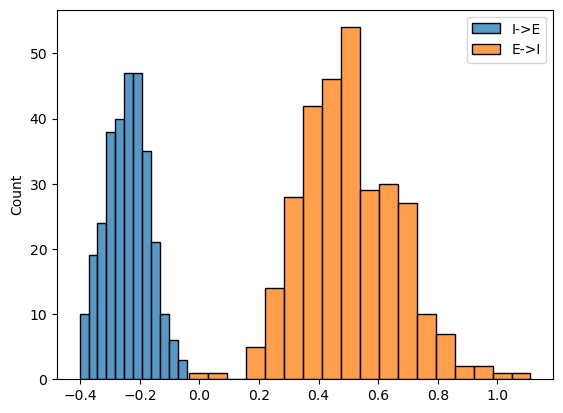

In [40]:
sns.histplot(all_w_initial[3][:n_e, n_e:].flatten(), color='C0', label='I->E')
sns.histplot(all_w_initial[3][n_e:, :n_e].flatten(), color='C1', label='E->I')
#sns.histplot(all_w_initial[3][:n_e, :n_e].flatten(), color='C2', label='E->E')
plt.legend()

## Input rates

In [41]:
# Input rates for excitatory neurons
r_in_e_0 = np.zeros((len(t), n_e))

# Set gaussian pulse for last and first 2 neurons
r_in_e_0[:, -1] = generate_gaussian_pulse(t, 5e-3, 5e-3, w=0.01 * 0.5)
r_in_e_0[:, 0] = generate_gaussian_pulse(t, 5e-3, 5e-3, w=0.01)
r_in_e_0[:, 1] = generate_gaussian_pulse(t, 5e-3, 5e-3, w=0.01 * 0.5)

# 10 x n_e
r_target_0 = np.stack([[0.15149132, 0.11786643, 0.02162234, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02162234, 0.11786643] for k in range(10)])

all_r_in = [] # input rates for E and I neurons
all_r_target = [] # target rates, only for E neurons

for i in range(n_e):
	# n_t x n_neurons
	all_r_in.append(np.concatenate([np.roll(r_in_e_0, i, axis=1), np.zeros((len(t), n_i))], axis=1))
	# 10 x n_e
	all_r_target.append(np.roll(r_target_0, i, axis=1))

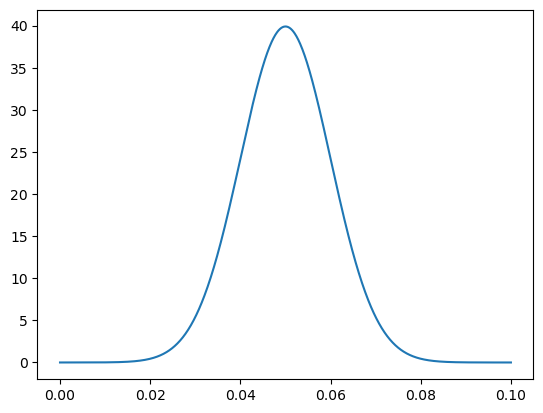

In [82]:
# Curious why amplitude depends on std dev?
plt.plot(t, generate_gaussian_pulse(t, 0.05, .01, 1))

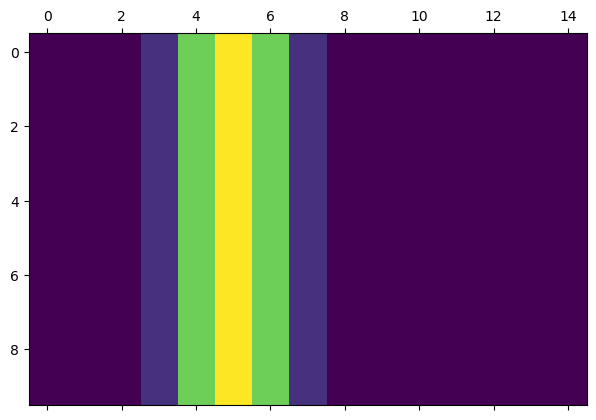

In [104]:
# Rate target is simply moving bump
plt.matshow(all_r_target[5])

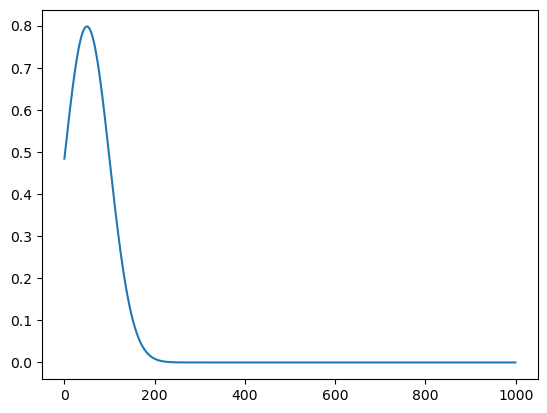

In [98]:
plt.plot(all_r_in[0][:, 0])

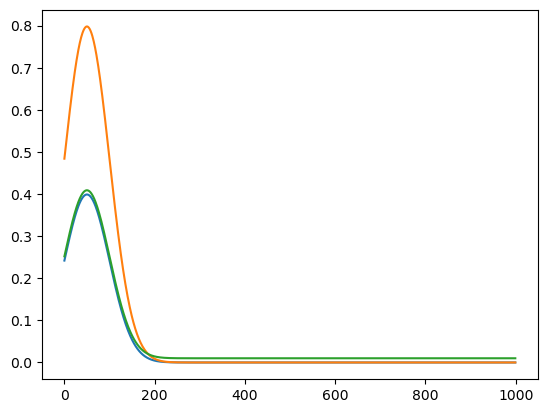

In [47]:
plt.plot(r_in_e_0[:, -1])
plt.plot(r_in_e_0[:, 0])
plt.plot(r_in_e_0[:, 1]+0.01)

In [5]:
# Defining L2 loss and objective function

def l2_loss(r, r_target):
	if np.isnan(r).any():
		return 100000
	return np.sum(np.square(r[(-1 * r_target.shape[0]):, :n_e] - r_target))

eval_tracker = {
	'evals': 0,
	'best_loss': np.nan,
}

def plot_results(results, n_res_to_show, eval_tracker, out_dir, title, plasticity_coefs, best=False):
	scale = 3
	if best:
		gs = gridspec.GridSpec(2 * n_res_to_show + 2, 2)
		fig = plt.figure(figsize=(4  * scale, (2 * n_res_to_show + 2) * scale), tight_layout=True)
		axs = [[fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1])] for i in range(2 * n_res_to_show)]
		axs += [fig.add_subplot(gs[2 * n_res_to_show, :])]
		axs += [fig.add_subplot(gs[2 * n_res_to_show + 1, :])]
	else:
		gs = gridspec.GridSpec(2 * n_res_to_show, 2)
		fig = plt.figure(figsize=(4  * scale, n_res_to_show * scale), tight_layout=True)
		axs = [[fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1])] for i in range(2 * n_res_to_show)]

	for i in range(n_res_to_show):
		r, w = results[i]

		axs[2 * i][0].imshow(r[:, :n_e].T, aspect='auto', interpolation='none')

		for l_idx in range(r.shape[1]):
			if l_idx >= n_e:
				axs[2 * i][1].plot(t, r[:, l_idx], c='black')

		axs[2 * i + 1][0].matshow(all_w_initial[i])
		axs[2 * i + 1][1].matshow(w)
		axs[2 * i][0].set_title(title)

	if best:
		plasticity_coefs_abs = np.abs(plasticity_coefs)
		plasticity_coefs_argsort = np.flip(np.argsort(plasticity_coefs_abs))
		axs[2 * n_res_to_show + 1].bar(np.arange(len(plasticity_coefs)), (plasticity_coefs / np.sum(plasticity_coefs_abs))[plasticity_coefs_argsort])
		axs[2 * n_res_to_show + 1].set_xticks(np.arange(len(plasticity_coefs)))
		axs[2 * n_res_to_show + 1].set_xticklabels(rule_names[plasticity_coefs_argsort], rotation=60, ha='right')
		axs[2 * n_res_to_show + 1].set_xlim(-1, len(plasticity_coefs))

		to_show = 10
		plasticity_coefs_argsort = plasticity_coefs_argsort[:to_show]
		axs[2 * n_res_to_show].bar(np.arange(to_show), (plasticity_coefs / np.sum(plasticity_coefs_abs))[plasticity_coefs_argsort])
		axs[2 * n_res_to_show].set_xticks(np.arange(to_show))
		axs[2 * n_res_to_show].set_xticklabels(rule_names[plasticity_coefs_argsort], rotation=60, ha='right')
		axs[2 * n_res_to_show].set_xlim(-1, to_show)


	pad = 4 - len(str(eval_tracker['evals']))
	zero_padding = '0' * pad
	evals = eval_tracker['evals']

	fig.tight_layout()
	if best:
		fig.savefig(f'{out_dir}/{zero_padding}{evals} best.png')
	else:
		fig.savefig(f'{out_dir}/{zero_padding}{evals}.png')

	plt.close('all')

def simulate_single_network(args, plasticity_coefs):
	w_initial, r_in = args[0], args[1]

	w = copy(w_initial)

	for i in range(N_INNER_LOOP_ITERS):
		r, s, v, w_out = simulate(t, n_e, n_i, r_in + + 2e-6 / dt * np.random.rand(len(t), n_e + n_i), transfer_e, transfer_i, plasticity_coefs, w, dt=dt, tau_e=10e-3, tau_i=0.1e-3, g=1, w_u=0.5)
		if np.isnan(r).any():
			return r, w
		if (np.abs(w_out - w) <= (0.02 * np.abs(w))).all():
			return r, w_out
		w = w_out

	return r, w

# Function to minimize (including simulation)

def simulate_plasticity_rules(plasticity_coefs, eval_tracker=None):
	start = time.time()

	input_indices_to_test = np.stack([np.random.choice(np.arange(n_e), size=3, replace=False) for i in range(N_NETWORKS)])

	pool = mp.Pool(POOL_SIZE)
	f = partial(simulate_single_network, plasticity_coefs=plasticity_coefs)
	args = []
	for i in range(N_NETWORKS):
		for j in range(input_indices_to_test[i].shape[0]):
			args.append((all_w_initial[i], all_r_in[input_indices_to_test[i, j]]))
	results = pool.map(f, args)
	pool.close()

	loss = np.sum([l2_loss(res[0], all_r_target[input_indices_to_test.flatten()[k]]) for k, res in enumerate(results)]) + L1_PENALTY * N_NETWORKS * np.sum(np.abs(plasticity_coefs))

	if eval_tracker is not None:
		if np.isnan(eval_tracker['best_loss']) or loss < eval_tracker['best_loss']:
			if eval_tracker['evals'] > 0:
				eval_tracker['best_loss'] = loss
			plot_results(results, N_NETWORKS, eval_tracker, out_dir, f'Loss: {loss}\n', plasticity_coefs, best=True)
		eval_tracker['evals'] += 1

	dur = time.time() - start
	print('duration:', dur)
	print('guess:', plasticity_coefs)
	print('loss:', loss)
	print('')

	return loss

In [17]:
np.array(all_r_in).shape

(15, 1000, 35)

In [12]:
np.array(all_w_initial).shape

(10, 35, 35)

In [15]:
np.stack([np.random.choice(np.arange(n_e), size=3, replace=False) for i in range(N_NETWORKS)])[0, 0]

8

In [16]:
simulate_single_network(plasticity_coefs=np.zeros(117), args=(all_w_initial[0], all_r_in[0]))

ValueError: operands could not be broadcast together with shapes (117,1,1) (16,15,15) 

In [6]:
simulate_plasticity_rules(np.zeros(117), eval_tracker=eval_tracker)

x0 = np.zeros(117)
options = {
	'verb_filenameprefix': os.path.join(out_dir, 'outcmaes/'),
}

x, es = cma.fmin2(partial(simulate_plasticity_rules, eval_tracker=eval_tracker), x0, STD_EXPL, options=options)
print(x)
print(es.result_pretty())


Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'simulate_single_network' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/riekelabbackup/opt/anaconda3/envs/rnn/lib/python3.1

KeyboardInterrupt: 